# Ensemble Methods

combine multiple simple linear regression models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [7, 5]
%matplotlib inline

# The data
We use the [FIFA 22 player dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset?select=players_22.csv). 
 
Download the data from moodle: *players_22.csv*    

The dataset contains a large number of attributes for each football player in the FIFA 22 game.   

The goal of this exercise is to train a sklearn [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) to estimate the *overall* attribute of a player based on some skill-attributes.


In [2]:
# Load the data
df = pd.read_csv('players_22.csv')

# Display the first 5 rows
df.head()


C:\Users\lars.herrmann\AppData\Local\Temp\ipykernel_11616\2172517237.py:2: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('players_22.csv')


,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


# Data Selection, Data Preparation
 

1. Feature Selection  
The list `numerial_feature_names` contain possible candidates to use as features in the regression task.
Select a subset of ~ 6-12 features you want to use for the prediction of the *overall* attribute.  


2. Create a `data` DataFrame object containing only your selected features and the target varaible.
3. Explore this reduced dataset with methods you learned in previous weeks.
    - How many samples are in the dataset?
    - Whats the mean of the *overall* attribute?
    - Make a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html). (Note: Since there are many samples, the pair plot can take some time to complete, and the plots become too packed. Use just a subset of samples for plotting. (Hint: [DataFrame.sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)))    
<br/><br/>     
4. Data Cleansing  
    It is important to know if you have invalid / missing values in your dataset. You can use `DataFrame.isnull().sum()` to get the number of missing values for each column in your dataset.   
Depending on the project, there are different options how to deal with null values.
We will use a very simple strategy of dropping rows containing null values. ([DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)) 

    In a real project, you would have to *carefully evaluate* those null values! What other methods can you think of for dealing with null values?

5. Data Preparation
    - Prepare the data to have features `X` and a target variable `y`.
    - Use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into 80% training data and 20% test data.

In [3]:
target_name = 'overall'

numerial_feature_names = ['pace', 'shooting','passing','dribbling','defending',
                 'physic','attacking_crossing','attacking_finishing',
                 'attacking_heading_accuracy','attacking_short_passing',
                 'attacking_volleys','skill_dribbling','skill_curve',
                 'skill_fk_accuracy','skill_long_passing','skill_ball_control',
                 'movement_acceleration','movement_sprint_speed','movement_agility',
                 'movement_reactions','movement_balance','power_shot_power',
                 'power_jumping','power_stamina','power_strength','power_long_shots',
                 'mentality_aggression','mentality_interceptions','mentality_positioning',
                 'mentality_vision','mentality_penalties','mentality_composure',
                 'defending_marking_awareness','defending_standing_tackle',
                 'defending_sliding_tackle']


feature_names = []

In [4]:
### EXAMPLE SOLUTION

# For simplicity, in this example we will just use some features that are most correlated with the target variable
correlations = df[numerial_feature_names].corrwith(df[target_name])
correlations = correlations.sort_values(ascending=False)

print(correlations)

feature_names = correlations.index[:8]

# In practice, you should consider all features and then use feature selection methods to select the most important features

movement_reactions             0.871823
passing                        0.715001
mentality_composure            0.708867
dribbling                      0.666402
power_shot_power               0.561180
physic                         0.529234
mentality_vision               0.523025
attacking_short_passing        0.516788
skill_long_passing             0.498216
shooting                       0.489623
skill_ball_control             0.460411
skill_curve                    0.420423
power_long_shots               0.410010
attacking_crossing             0.401356
mentality_aggression           0.400161
power_stamina                  0.385150
skill_dribbling                0.384351
skill_fk_accuracy              0.381030
attacking_volleys              0.380942
power_strength                 0.364366
mentality_positioning          0.358562
defending                      0.346760
attacking_heading_accuracy     0.343901
mentality_penalties            0.343690
attacking_finishing            0.338746


In [5]:
# Create a new dataframe with the target variable and the selected features
data = df[[target_name, *feature_names]]

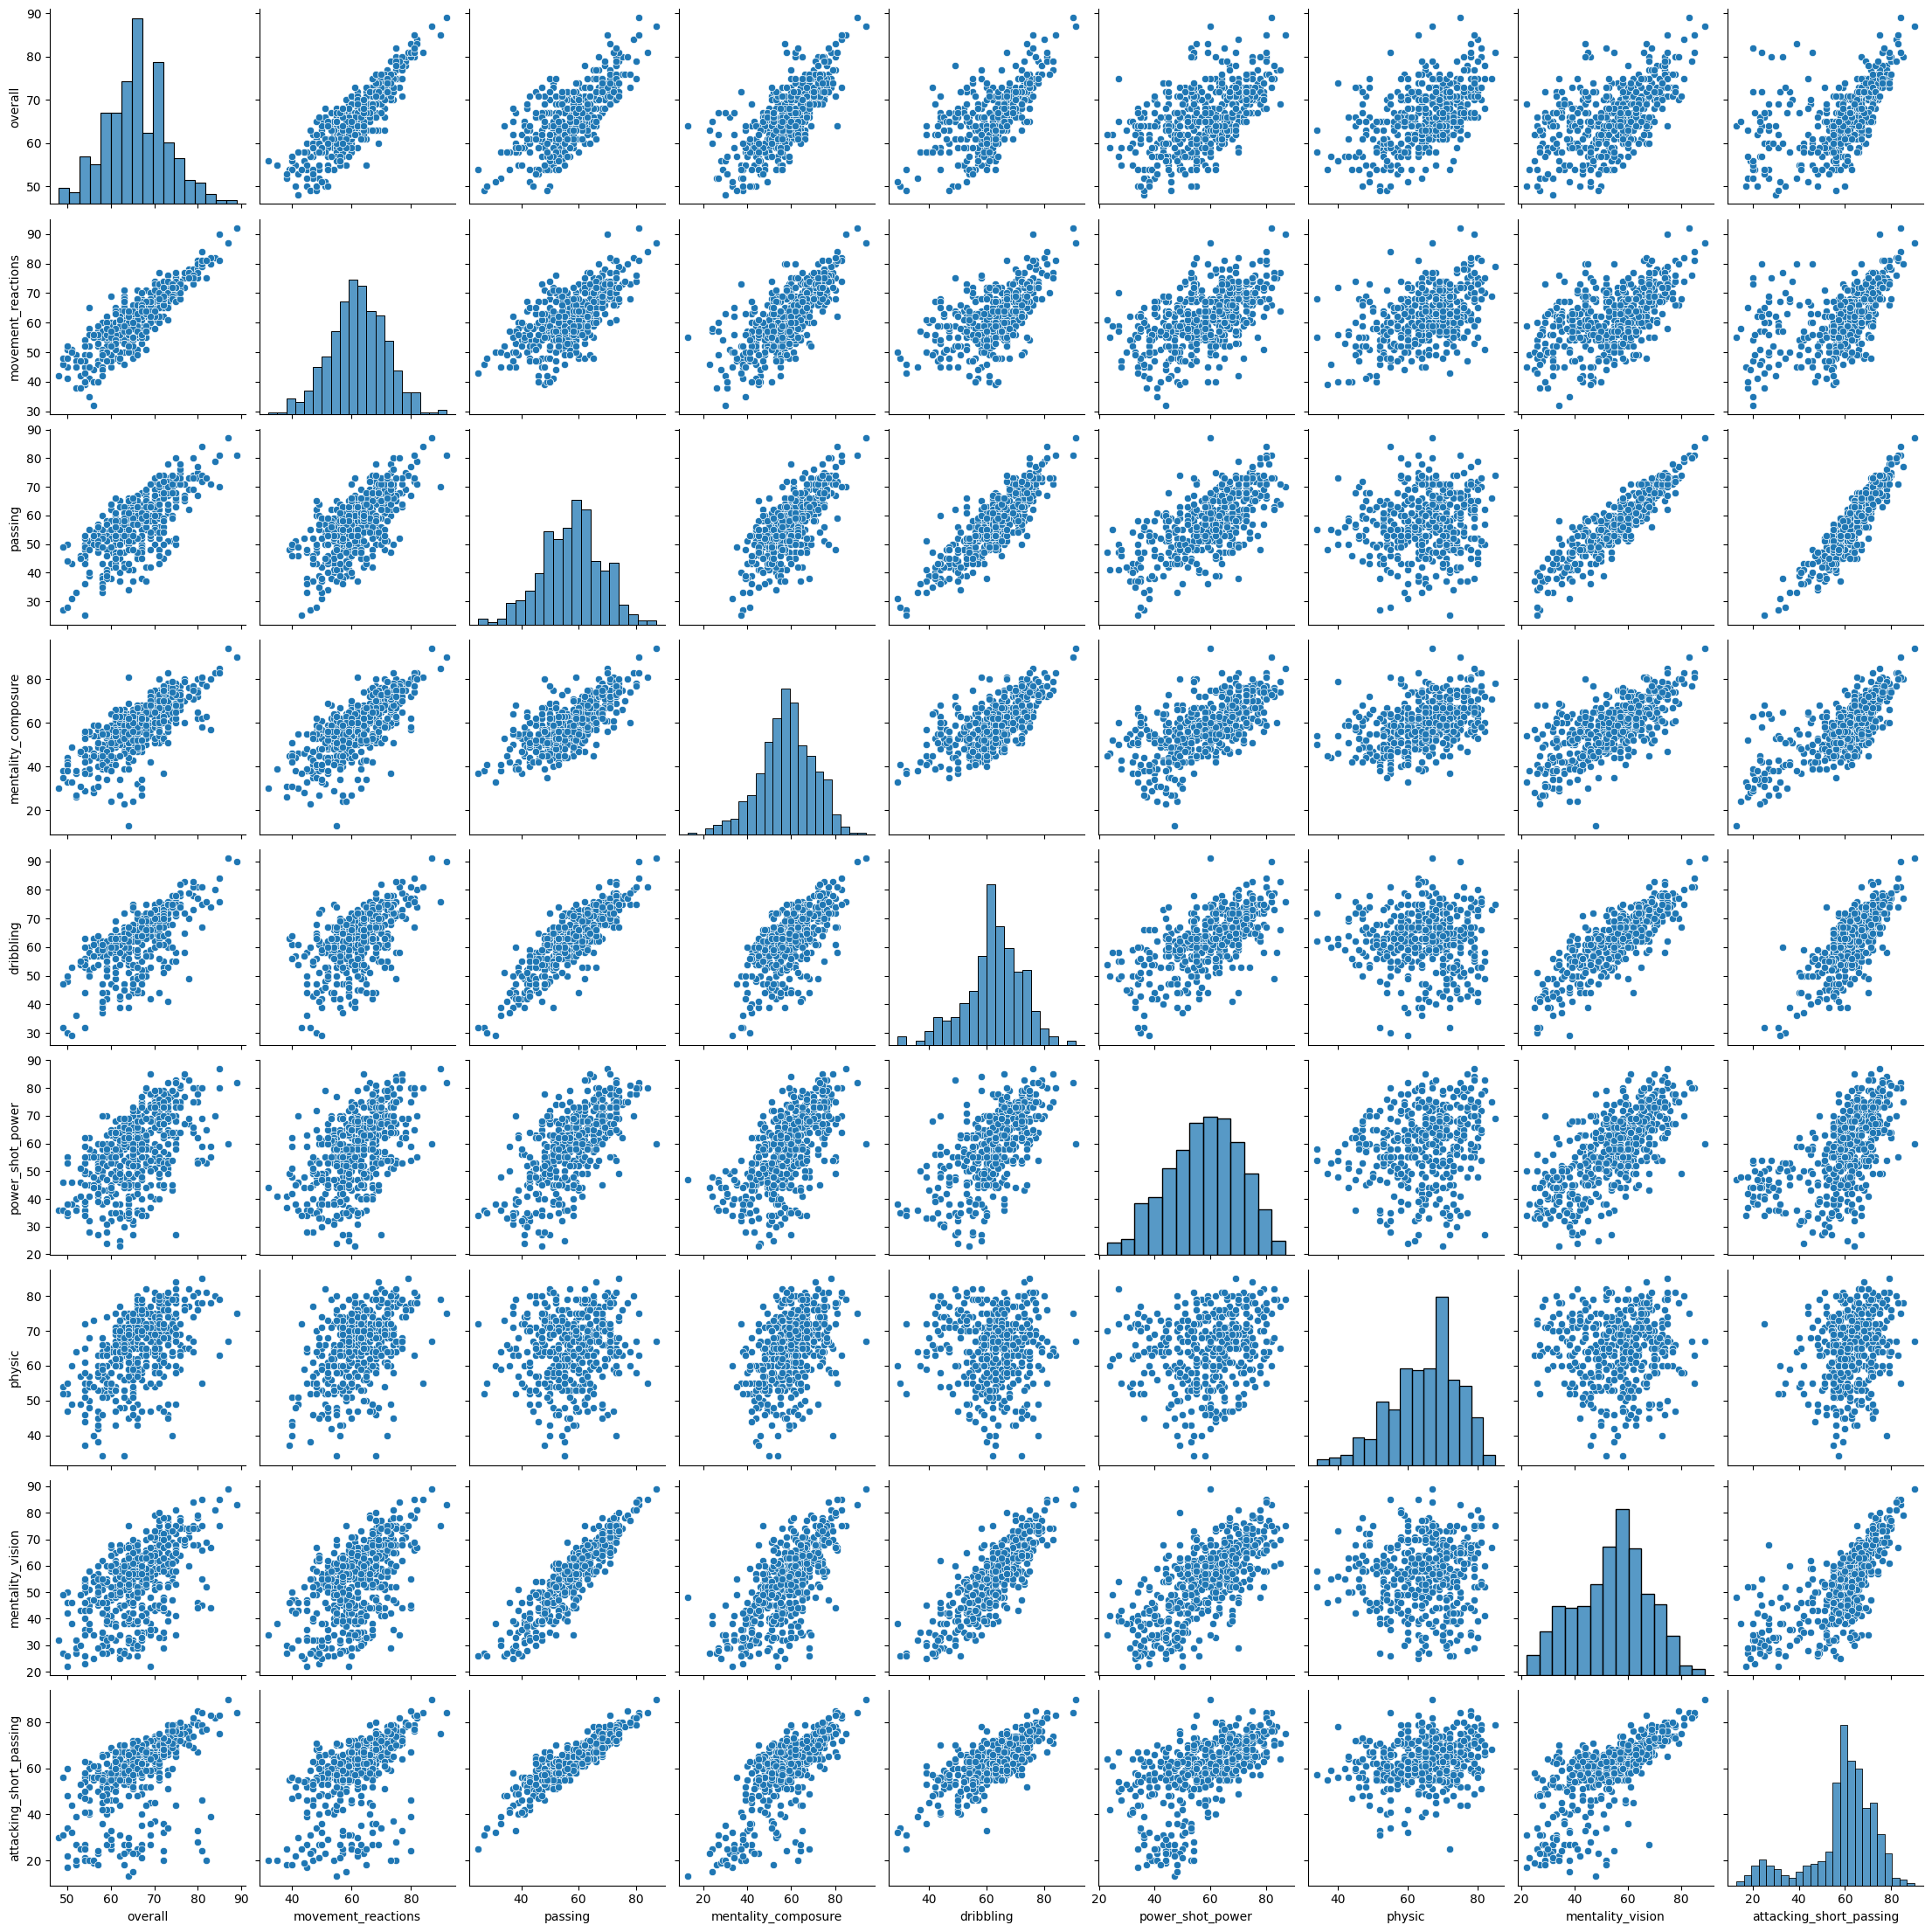

In [6]:
sns.pairplot(data.sample(500))

In [7]:
data.describe()

,overall,movement_reactions,passing,mentality_composure,dribbling,power_shot_power,physic,mentality_vision,attacking_short_passing
count,19239.000000,19239.000000,17107.000000,19239.000000,17107.000000,19239.000000,17107.000000,19239.000000,19239.000000
mean,65.772182,61.450023,57.312562,57.929830,62.561174,57.776860,64.823289,53.964603,58.867977
std,6.880232,9.042281,10.068965,12.159326,9.651312,13.192224,9.791886,13.650481,14.490858
min,47.000000,25.000000,25.000000,12.000000,27.000000,20.000000,29.000000,10.000000,7.000000
25%,61.000000,56.000000,51.000000,50.000000,57.000000,48.000000,59.000000,45.000000,54.000000
50%,66.000000,62.000000,58.000000,59.000000,64.000000,59.000000,66.000000,55.000000,62.000000
75%,70.000000,67.000000,64.000000,66.000000,69.000000,68.000000,72.000000,64.000000,68.000000
max,93.000000,94.000000,93.000000,96.000000,95.000000,95.000000,90.000000,95.000000,94.000000


In [8]:
# Check if there are any missing values
print(data.isnull().sum())

overall                       0
movement_reactions            0
passing                    2132
mentality_composure           0
dribbling                  2132
power_shot_power              0
physic                     2132
mentality_vision              0
attacking_short_passing       0
dtype: int64


In [9]:
# Drop rows with missing values
data = data.dropna()
data.describe()

,overall,movement_reactions,passing,mentality_composure,dribbling,power_shot_power,physic,mentality_vision,attacking_short_passing
count,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000,17107.000000
mean,65.940726,61.877828,57.312562,60.049278,62.561174,59.189162,64.823289,55.847782,62.827907
std,6.771037,8.707776,10.068965,10.266863,9.651312,13.187949,9.791886,12.601153,9.303342
min,47.000000,29.000000,25.000000,30.000000,27.000000,20.000000,29.000000,13.000000,23.000000
25%,62.000000,56.000000,51.000000,53.000000,57.000000,51.000000,59.000000,48.000000,58.000000
50%,66.000000,62.000000,58.000000,60.000000,64.000000,61.000000,66.000000,57.000000,64.000000
75%,70.000000,68.000000,64.000000,67.000000,69.000000,69.000000,72.000000,65.000000,69.000000
max,93.000000,94.000000,93.000000,96.000000,95.000000,95.000000,90.000000,95.000000,94.000000


In [10]:
from sklearn.model_selection import train_test_split

X = data[feature_names]
y = data[target_name]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model
Start with a single [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) model to get an idea of the performance you can expect.

We have not covered DecisionTrees in class. But you can use it as blackbox classifier.

1. Implement it as a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the data before fitting.
1. Fit the model on the training data.
1. Use [metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) to evaluate your model on the test data.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Create a pipeline with a scaler and a decision tree regressor
model_simple = DecisionTreeRegressor(max_depth=5, random_state=0)
model_pipe_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_simple)
])

# Fit the model on the training set
model_pipe_simple.fit(X_train, y_train)

# Evaluate the model on the test set
y_hat_test = model_pipe_simple.predict(X_test)
mse = mean_squared_error(y_test, y_hat_test)
print(f'MSE: {mse:.2f}')

score = model_pipe_simple.score(X_test, y_test)
print('R2: {:.3f}'.format(score))


MSE: 7.13
R2: 0.845


# Ensemble Method
When composing an ensemble, we have different choices:  
- The models can have different algorithms
- The models can use different features
- The models can be trained on different data

For this exercise, we use an ensemble of decision trees.

1. Use the [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) to combine estimators. (Start with `n_estimators=100` and `learning_rate=0.01`)
1. Implement it as a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the data before fitting.
1. Fit the model on the training data.
1. Use [metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) to evaluate your model on the test data.

How much better does this boosted regressor perform than the simple linear model?

In [12]:
from sklearn.ensemble import AdaBoostRegressor

# Create a pipeline with a scaler and a gradient boosting regressor
model_boosting = AdaBoostRegressor(base_estimator=model_simple, n_estimators=100, learning_rate=0.01, random_state=0)

model_pipe_boosting = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_boosting)
])

# Fit the model on the training set
model_pipe_boosting.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model_pipe_boosting.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

score = model_pipe_boosting.score(X_test, y_test)
print(f'R2: {score:.3f}')

MSE: 5.90
R2: 0.871


> in this example, the boosted model improved the MSE by **1.23** $(7.13 \rarr 5.90)$ 

# Hyperparameter Tuning
1. Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to perform 3-fold cross-validation to find some good values for `n_estimators`, `max_depth` and `learning_rate`.

Note max_depth is a hyperparameter for decision trees.

2. Use [metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) to evaluate your model on the test data.


In [13]:

from sklearn.model_selection import GridSearchCV

# Create a parameter grid
param_grid = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 1.0],
    'model__base_estimator__max_depth': [3, 5, 7]
}

# Create a grid search object
grid_search = GridSearchCV(model_pipe_boosting, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

score = grid_search.score(X_test, y_test)
print(f'R2: {score:.3f}')


{'model__base_estimator__max_depth': 7, 'model__learning_rate': 1.0, 'model__n_estimators': 200}
MSE: 3.89
R2: -3.888


> in this example, selection of different hyperparameters improved the MSE by **2.01**  $(5.90 \rarr 3.89 )$